In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
np.random.seed(1)

In [65]:
prices = pd.read_csv("FB-stock-prices.csv")
prices.head()

,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


In [66]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    251 non-null    object
 1   Price   251 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


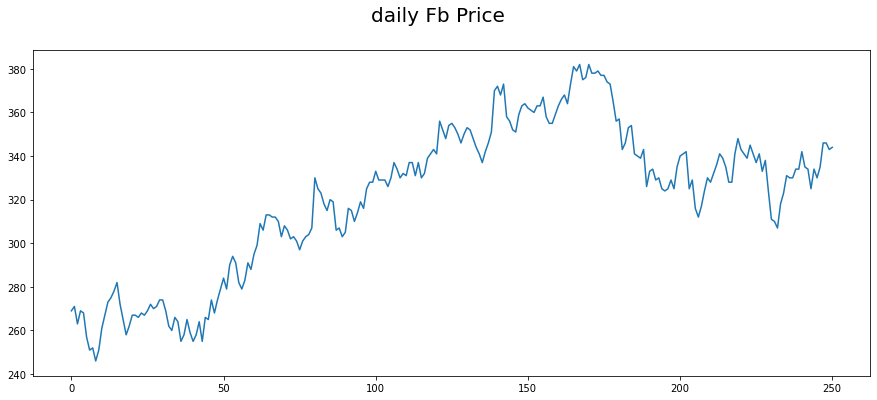

In [67]:
plt.figure(figsize=(15,6)).suptitle("daily Fb Price", fontsize=20)
plt.plot(prices["Price"])
plt.show()

In [68]:
# split data
from sklearn.preprocessing import StandardScaler
# scale data
scaler = StandardScaler()
scaled_price = scaler.fit_transform(prices[["Price"]].values)

# split data into training and test sets
total_size = len(scaled_price)
total_size

251

In [69]:
# test data
test_size = int(total_size * 0.2)
test_size

50

In [70]:
train_size = total_size - test_size
print(train_size)

201


In [71]:
training_prices = scaled_price[0:train_size, :]
test_prices = scaled_price[train_size:,:]
print(training_prices.shape, test_prices.shape)

(201, 1) (50, 1)


In [72]:
training_prices[1:(1+25),0]

array([-1.4393189 , -1.66896946, -1.49673154, -1.52543786, -1.84120738,
       -2.01344531, -1.98473899, -2.15697691, -2.01344531, -1.7263821 ,
       -1.55414418, -1.38190626, -1.32449362, -1.23837465, -1.12354937,
       -1.41061258, -1.61155682, -1.81250106, -1.69767578, -1.55414418,
       -1.55414418, -1.5828505 , -1.52543786, -1.55414418, -1.49673154])

In [73]:
training_prices[(1+25),0]

-1.4106125775593088

In [74]:
# create data set for RNN data= stock price and lookback window
def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

In [75]:
# look back for 25 previous das
lookback = 25

#create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_prices, lookback)

In [76]:
train_req_x.shape

(175, 25)

In [77]:
train_req_y.shape

(175,)

In [78]:
# reshape for use with RNN. RNN expect 3D shape: (batch size, time_steps, input_feature)
# Here (no. of samples, stock price=1, look back)
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))
print("Shape of X, Y: ", train_req_x.shape, train_req_y.shape)

Shape of X, Y:  (175, 1, 25) (175,)


In [79]:
# Build RNN model
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import tensorflow as tf

In [80]:
tf.random.set_seed(3)

In [81]:
# create a keras model
price_model = Sequential()
# add simple RNN layer with 32 nodes
price_model.add(SimpleRNN(32, input_shape=(1, lookback)))

# add a dense layer at end for output
price_model.add(Dense(1))

# compile with adam optimizer. Optimize for mean square error
price_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [82]:
price_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
# Train the model
price_model.fit(train_req_x, train_req_y, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
175/175 [==============================] - 2s 2ms/step - loss: 0.2347 - mse: 0.2347
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0565 - mse: 0.0565
Epoch 3/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0431 - mse: 0.0431
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0394
Epoch 5/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0380


In [84]:
# Test the model
test_req_x, test_req_y = create_rnn_dataset(test_prices, lookback)
print(test_req_x.shape, test_req_y.shape)

(24, 25) (24,)


In [85]:
# reshape the test data to fit in RNN data set
test_req_x = np.reshape(test_req_x, 
                        (test_req_x.shape[0], 1, test_req_x.shape[1]))
print("shape of test x and y: ", test_req_x.shape, test_req_y.shape)

shape of test x and y:  (24, 1, 25) (24,)


In [86]:
# Evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

1/1 [==============================] - 0s 453ms/step - loss: 0.0722 - mse: 0.0722


[0.0721840038895607, 0.0721840038895607]

In [87]:
# predict on test data set
predict_on_test = price_model.predict(test_req_x)

1/1 [==============================] - 0s 273ms/step


In [88]:
# Inverse the scaling to view result
predict_on_test = scaler.inverse_transform(predict_on_test)

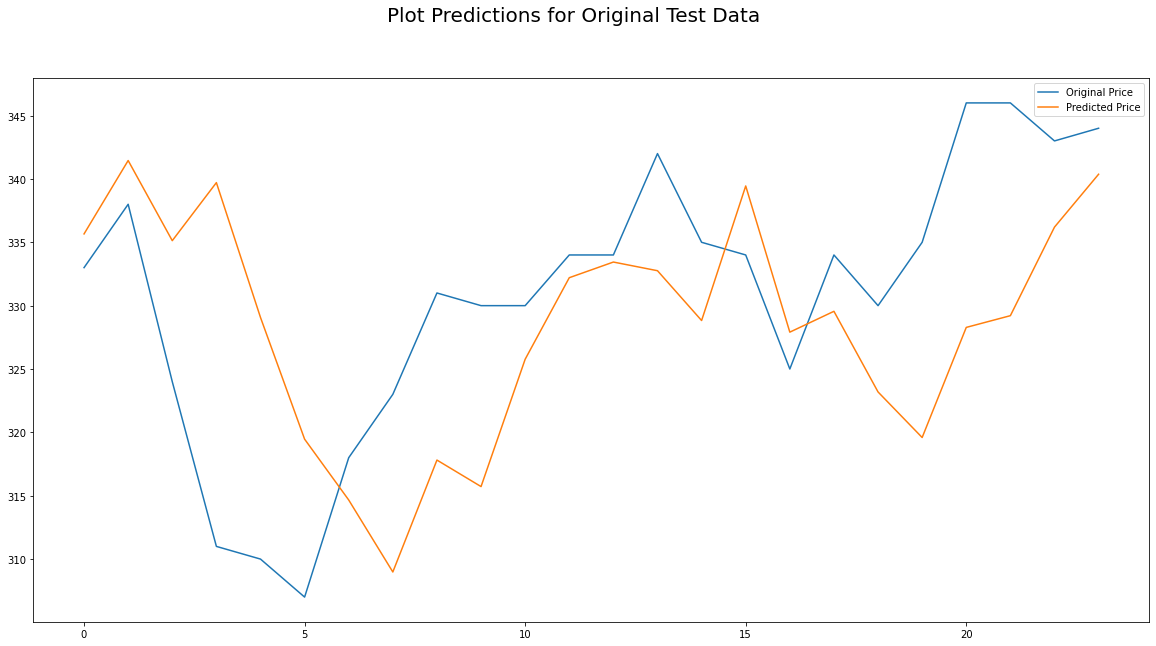

In [90]:
#Extract original test values that map to the same dates on the predicted test values
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

In [95]:
# Prediction
#Previous prices
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

# scale 
scaled_prices = scaler.transform(previous_prices.reshape(-1,1))
# Reshape for RNN 3D model
model_input = np.reshape(scaled_prices, (scaled_price.shape[1], 1, scaled_prices.shape[0]))
print("shape :", model_input.shape)

shape : (1, 1, 25)


In [101]:
# prediction
prediction = price_model.predict(model_input)
# scale back
norm_prediction = scaler.inverse_transform(prediction)

print("The Predcited stock price is : ", norm_prediction[0][0])

1/1 [==============================] - 0s 27ms/step
The Predcited stock price is :  333.94073
